In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import glob
from scipy.optimize import minimize
from scipy.interpolate import interp2d
import skimage.exposure as skie
!pip install photutils
from photutils import Background2D, MedianBackground, CircularAnnulus, aperture_photometry, CircularAperture, DAOStarFinder
from astropy.stats import mad_std
from astropy.stats import SigmaClip
!pip install opencv-contrib-python
import cv2
from astropy.stats import sigma_clipped_stats

In [2]:
def mk_master_by_median(list_of_imgs, plot_q=False):
    
    # Make a master image from a list of images
    
    list_of_imgs = [os.path.join(img_dir, fn) for fn in list_of_imgs]
    
    # Load the images
    imgs = []
    for fn in list_of_imgs:
        
        print('Loading', fn)
        
        imgs.append(fits.getdata(fn))
        
    print(np.shape(np.stack(imgs, axis=2)))
    
    # Calculate the meadian of the images
    mstr_img = np.nanmedian(np.stack(imgs, axis=2), axis=2)
    
    if plot_q:
        # Plot the median image
        plt.figure()
        plt.imshow(mstr_img, cmap='gray')
    
    return mstr_img


def plt_v1(img0, t1, t2, cmap='gray', rescale_img_q=False):
    
    # Plot an image with a zoom subplot
    
    avg = str(np.around(np.nanmean(img0), 2))
    sd = str(np.around(np.nanstd(img0), 2))
    
    if rescale_img_q:
        img = rescale_img(np.copy(img0))
    else:
        img = img0
    
    # Show the full image
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap=cmap, origin='bottom')
    plt.title(t1 + '  |  avg=' + avg + '  |  SD=' + sd)

    # Show a small section of the image
    plt.subplot(1,2,2)
    plt.imshow(img[200:250, 500:550], cmap=cmap, origin='bottom')
    plt.title(t2)
    
    
def plt_input_imgs(list_of_imgs0, cmap='gray', rescale_img_q=False):
    
    # plot a list of images (paths)
    
    list_of_imgs = [os.path.join(img_dir, fn) for fn in list_of_imgs0]
    
    # Load the images
    imgs = []
    for fn in list_of_imgs:
        
        print('Loading', fn)
        
        imgs.append(fits.getdata(fn))
    
    
    # Plot the images in a grid
    from mpl_toolkits.axes_grid1 import ImageGrid
    
    n = np.int32(np.ceil(np.sqrt(len(imgs))))
    
    fig = plt.figure(figsize=(15,10))
    
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n, n),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    i = 0
    for ax, im in zip(grid, imgs):
        
        # Iterating over the grid returns the Axes.
        ax.imshow(rescale_img(im), cmap=cmap, origin='bottom')
        ax.set_title(list_of_imgs0[i])
        i+=1

    plt.show()
    
    
def plt_input_imgs2(imgs, list_of_imgs0, cmap='gray', rescale_img_q=False):
    
    # plot a list of images
    
    # Plot the images in a grid
    from mpl_toolkits.axes_grid1 import ImageGrid
    
    n = np.int32(np.ceil(np.sqrt(len(imgs))))
    
    fig = plt.figure(figsize=(15,10))
    
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n, n),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    i = 0
    for ax, im in zip(grid, imgs):
        
        # Iterating over the grid returns the Axes.
        ax.imshow(rescale_img(im), cmap=cmap, origin='bottom')
        if len(list_of_imgs0) > 1:
            ax.set_title(list_of_imgs0[i])
        i+=1

    plt.show()
    
    
def rescale_img(img):
    
    # rescale the flux of an image
    
    import skimage.exposure as skie

    # Determine upper and lower percentiels of our img flux
    low = np.percentile(img, 0.25)
    high = np.percentile(img, 99.5)
    
    # Rescale the flux so that the min/max is the percentile LB/UB
    return skie.exposure.rescale_intensity(img, in_range=(low, high))

In [3]:
def minfun(dxy, x, y, i_obs, itmp_pp, var_scalers):
    
    # minimization function for image alignment

    # Interpolate image to new alignment
    itmp_xdc = itmp_pp(x + dxy[0] / var_scalers[0], y + dxy[1] / var_scalers[1])
    
    # LSQ of both imgs
    return np.sum( (i_obs - itmp_xdc)**2 * np.abs(i_obs))


def rs(fimg2, lb, ub):
    
    # rescale the flux of an image
    
    # Normalize
    image_gray = fimg2 / np.nanmax(fimg2)

    image_gray[np.isnan(image_gray)] = 0.0

    # Similar to a log normalization. Decrease flux gradiants
    limg = np.arcsinh(image_gray)
    limg = limg / np.nanmax(limg)

    low = np.percentile(limg, lb)
    high = np.percentile(limg, ub)
    return skie.exposure.rescale_intensity(limg, in_range=(low, high))


def rs2(fimg2, mc, lb, ub):
    
    # rescale the flux of an image
    
    # Normalize
    image_gray = fimg2[:,:,mc]# / np.nanmax(fimg2[:,:,mc])

    image_gray[np.isnan(image_gray)] = 0.0

    # Similar to a log normalization. Decrease flux gradiants
    limg = np.arcsinh(image_gray)
    limg = limg / np.nanmax(limg)

    low = np.percentile(limg, lb)
    high = np.percentile(limg, ub)
    
    fimgrs = np.copy(fimg2)
    
    for i in range(3):
        limg = np.arcsinh(image_gray)
        limg = limg / np.nanmax(limg)
        
        fimgrs[:,:,i] = skie.exposure.rescale_intensity(limg, in_range=(low, high))
        
    return fimgrs

# Images Directory

In [4]:
# Where are all of the images located (full path)
img_dir = r'C:\Users\claire\Documents\_ research _\notebooks\myobs'

# Master Dark

## Check input images for major defects

Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\dark_25s_-001.fit
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\dark_25s_-002.fit
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\dark_25s_-003.fit
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\dark_25s_-004.fit
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\dark_25s_-005.fit


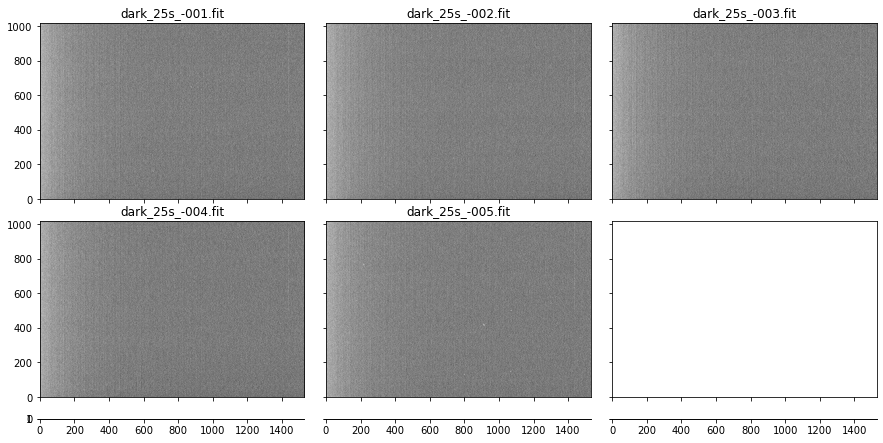

In [5]:
# Find all images to stack
list_of_darks = [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, 'dark_25s*.fit'))]

# Plot the images that will be stacked
plt_input_imgs(list_of_darks, cmap='gray', rescale_img_q=True)

## Calculate median of the images

In [6]:
# Make the master image
mast_dark = mk_master_by_median(list_of_darks, plot_q=False)

# Get the exposure time for these images
dark_exptime = np.float64(fits.getheader(os.path.join(img_dir, list_of_darks[0]))['EXPTIME'])

Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\dark_25s_-001.fit
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\dark_25s_-002.fit
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\dark_25s_-003.fit
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\dark_25s_-004.fit
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\dark_25s_-005.fit
(1020, 1530, 5)


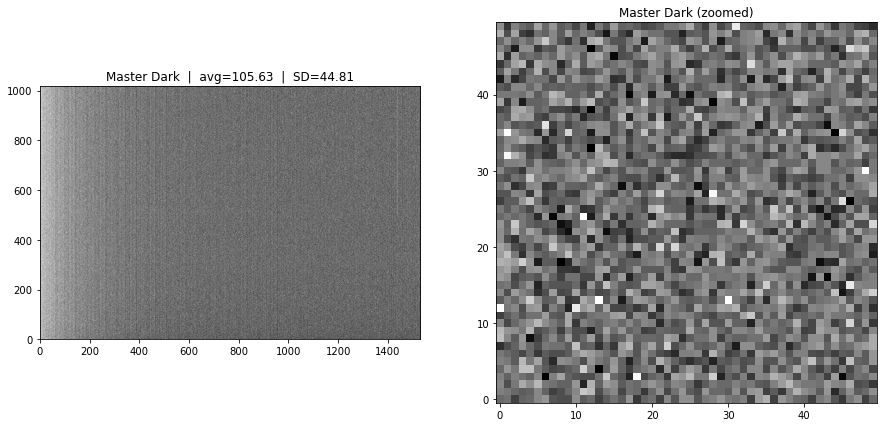

In [7]:
# Plot the median image
plt_v1(mast_dark, 
       t1='Master Dark', 
       t2='Master Dark (zoomed)', 
       cmap='gray', 
       rescale_img_q=True)

# Master Flat

## Check input images for major defects

Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_I_2_002.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_I_2_009.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_I_2_011.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_I_2_014.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_I_2_016.fits


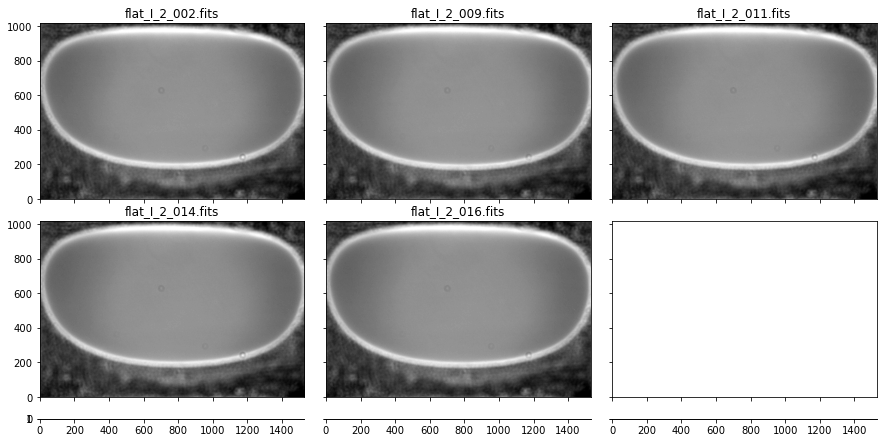

Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_V_10_003.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_V_10_005.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_V_10_006.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_V_10_010.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_V_10_013.fits


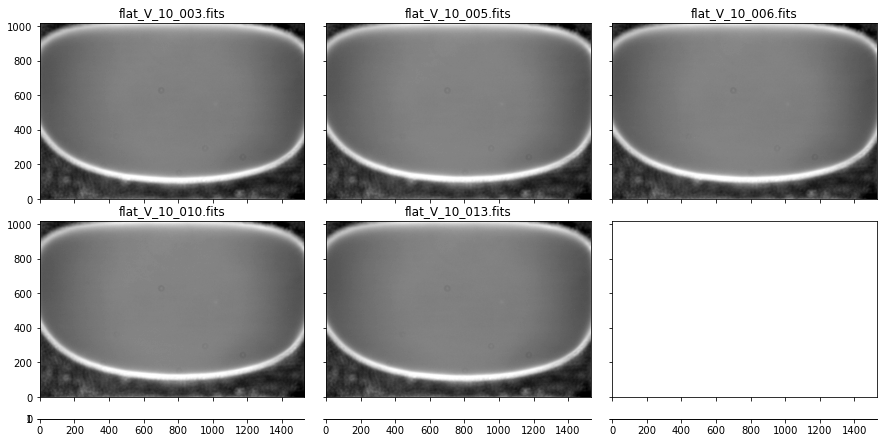

In [8]:
# Filter letter
mag_strs = ['I', 'V']

# Find all images to stack
flat_paths = []
for n in ['flat_I*.*', 'flat_V*.*']:
    flat_paths.append( [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, n))] )


for list_of_imgs, cstr in zip(flat_paths, mag_strs):
    
    plt_input_imgs(list_of_imgs, cmap='gray', rescale_img_q=True)

In [9]:
# Get the exposure time for these images
flat_i_exptime = np.float64(fits.getheader(os.path.join(img_dir, flat_paths[0][0]))['EXPTIME'])

# Get the exposure time for these images
flat_v_exptime = np.float64(fits.getheader(os.path.join(img_dir, flat_paths[1][0]))['EXPTIME'])

flat_i_exptime, flat_v_exptime

(2.0, 10.0)

## Calculate median of the images

In [10]:
mast_flats = []

for list_of_imgs, cstr in zip(flat_paths, mag_strs):
    
    mast_flats.append(mk_master_by_median(list_of_imgs, plot_q=False))

Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_I_2_002.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_I_2_009.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_I_2_011.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_I_2_014.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_I_2_016.fits
(1020, 1530, 5)
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_V_10_003.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_V_10_005.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_V_10_006.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_V_10_010.fits
Loading C:\Users\claire\Documents\_ research _\notebooks\myobs\flat_V_10_013.fits
(1020, 1530, 5)


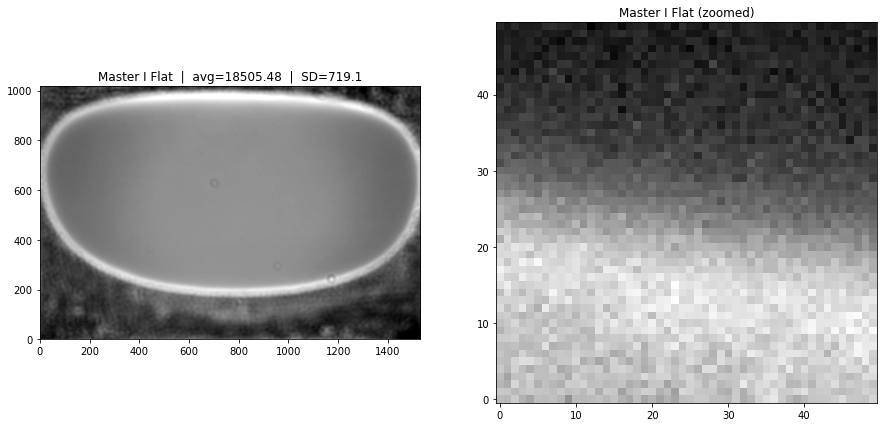

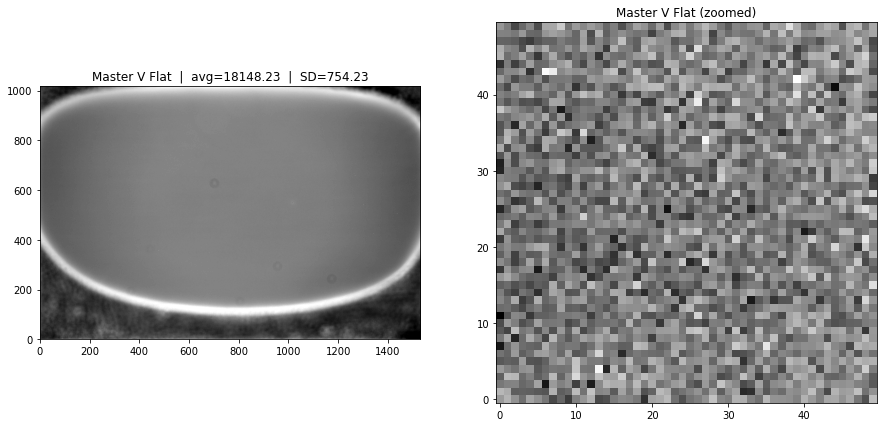

In [11]:
# Plot the median images

for mast_flat, cstr in zip(mast_flats, mag_strs):
    
    plt_v1(mast_flat, 
           t1='Master ' + cstr + ' Flat', 
           t2='Master ' + cstr + ' Flat (zoomed)', 
           cmap='gray', 
           rescale_img_q=True)

# Science images

In [12]:
# What is the object name (this should appear in the file name)
#obj_name = 'M78'
#obj_name = 'West'
#obj_name = 'Zenith'
#obj_name = 'HD47240'
obj_name = 'M15'

# Find all images to stack
sci_paths = []
for n in ['_I_3*.*', '_V_8*.*']:
    
    sci_paths.append( [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, obj_name + n))] )

# Plot all images found
if 0:
    for list_of_imgs, cstr in zip(sci_paths, mag_strs):

        plt_input_imgs(list_of_imgs, cmap='gray', rescale_img_q=0)

In [13]:
# Filter down to N images per color filter by picking the images with
#   the highest standard deviations.

if 1: # 0 turns it off, 1 turns it on
    
    N = 12 # How many images to keep of each color filter
    
    newlists = [[],[],[]]
    
    for list_of_imgs, cstr, cn in zip(sci_paths, mag_strs, [0, 1]):
        
        sf = []
        
        for i, fn in enumerate(list_of_imgs):
            
            sf.append( np.nanstd(fits.getdata(os.path.join(img_dir, fn))) )
            
        si = np.flip(np.argsort(sf))
        
        #print(len(si), len(si[:N]), len([list_of_imgs[ix] for ix in si[:N]]))
        
        newlists[cn] = [list_of_imgs[ix] for ix in si[:N]]
        
    sci_paths[0], sci_paths[1] = newlists[0], newlists[1]

In [14]:
# Manually determine which obs to keep

if 0: # 0 turns this off, 1 turns it on
    
    from IPython.display import clear_output
    
    newlists = [[],[],[]]

    for list_of_imgs, cstr, cn in zip(sci_paths, mag_strs, [0, 1]):
        
        for i, fn in enumerate(list_of_imgs):
            
            im = fits.getdata(os.path.join(img_dir, fn))
            
            print('***********************************************\n')
            print('Looking at ', fn , cstr, ' channel, obs ', i+1, ' of ', len(list_of_imgs), '\n')
            plt.pause(0.1)
            plt_v1(im, 
                   t1='Master ' + cstr + ' Flat', 
                   t2='Master ' + cstr + ' Flat (zoomed)', 
                   cmap='gray', 
                   rescale_img_q=True)
            plt.pause(0.1)
            
            ans = input('Press enter to keep or "n" to discard: ')
            if ans == '':
                
                newlists[cn].append(fn)
                
                
            clear_output()
            
    sci_paths[0], sci_paths[1] = newlists[0], newlists[1]

In [15]:
sci_imgs_0 = []
for list_of_imgs0, cstr, cn in zip(sci_paths, mag_strs, [0, 1]):

    list_of_imgs = [os.path.join(img_dir, fn) for fn in list_of_imgs0]   

    istack = []
    for fn in list_of_imgs:

        # Read the image
        istack.append( fits.getdata(fn) )
        
    sci_imgs_0.append( istack )

# Science image calibration

In [16]:
def calib(imgs, dark, flat, dark_exptime, flat_exptime, plot_q=False):
    
    # Calibrates each science image using the master dark and flat
    
    flat_div_avg = (flat / flat_exptime) / np.nanmean(flat)
    
    for i, img in enumerate(imgs):
        
        # Get the exposure time for this sci img
        #img_exptime = np.float64(fits.getheader(fn)['EXPTIME'])
        
        # Calibrate the image
        img = (img - dark / dark_exptime) * flat_div_avg
        
        imgs[i] = img
    
    return imgs

In [17]:
len(sci_imgs_0)

2

In [18]:
# Calibrate all of the science images

sci_imgs = []
for imgs, cstr, mast_flat, flat_exptime in zip(sci_imgs_0, mag_strs, mast_flats, [flat_i_exptime, flat_v_exptime]):

    sci_imgs.append( calib(imgs, mast_dark, mast_flat, dark_exptime, flat_exptime, plot_q=False) )

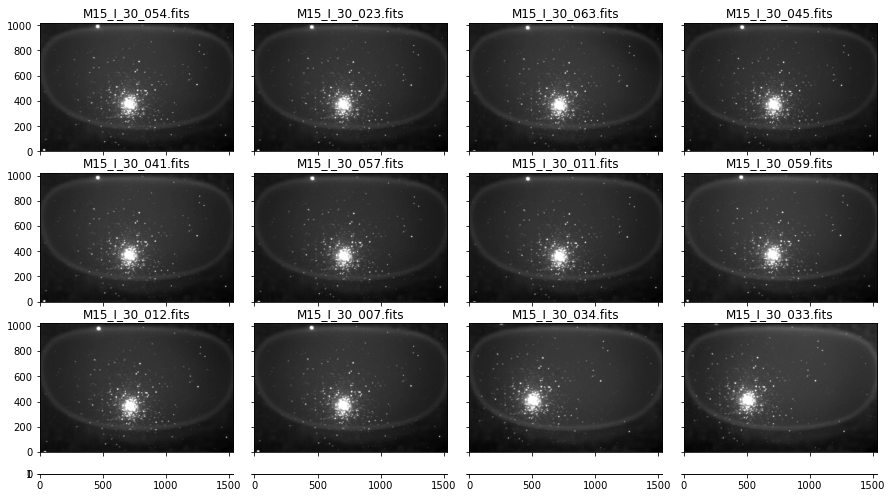

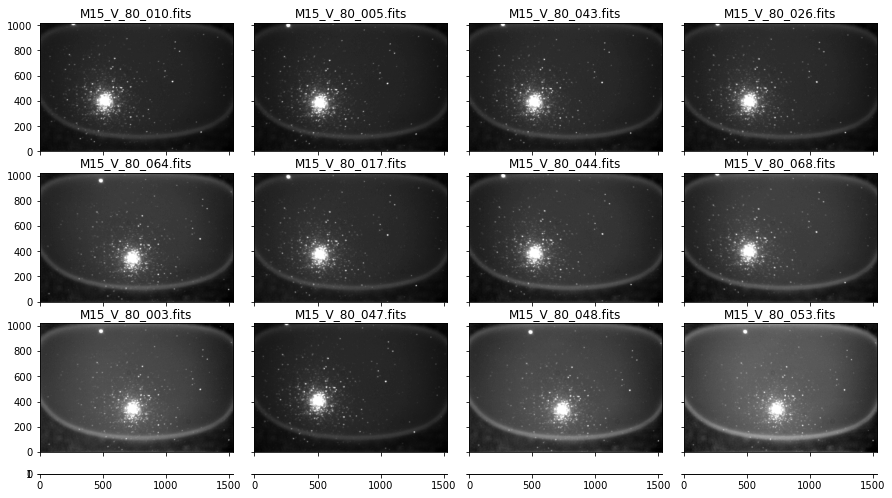

In [19]:
# Show all of the calibrated science images
if 1:
    for list_of_imgs, imgs, cstr in zip(sci_paths, sci_imgs, mag_strs):

        plt_input_imgs2(imgs, list_of_imgs, cmap='gray', rescale_img_q=0)

# Align science images

In [21]:
def align_two_imgs(img1, img2):
    
    # Align two images using the astropy method (fast & accurate)
    
    from skimage.feature import register_translation
    import scipy.ndimage as ndimage
    
    shift, error, diffphase = register_translation(img1, img2, upsample_factor=100)

    dx = shift[1]
    dy = shift[0]

    img2_shifted = ndimage.shift(img2, shift)
        
    return img2_shifted, dx, dy


def align_imgs3(imgs):
    
    # Align a list of images using the astropy method (fast & accurate)
    
    from skimage.feature import register_translation
    import scipy.ndimage as ndimage
    
    mstr_img = imgs[0]
    
    # Align the images
    imgs2, dxs, dys = [], [], []
    for img in imgs:

        shift, error, diffphase = register_translation(mstr_img, img, upsample_factor=100)
        
        dxs.append(shift[1])
        dys.append(shift[0])
        
        imgs2.append( ndimage.shift(img, shift) )
        
        mstr_img = np.nanmedian(np.stack(imgs2, axis=2), axis=2)
        
    mstr_img = mstr_img - np.nanmin(mstr_img)
        
    return mstr_img, dxs, dys

In [23]:
# Align all science images

mast_scis, mast_scis_dx, mast_scis_dy = [], [], []

for imgs in sci_imgs:

    mast_sci, dx, dy = align_imgs3(imgs)
    
    mast_scis.append(mast_sci)
    mast_scis_dx.append(dx)
    mast_scis_dy.append(dy)

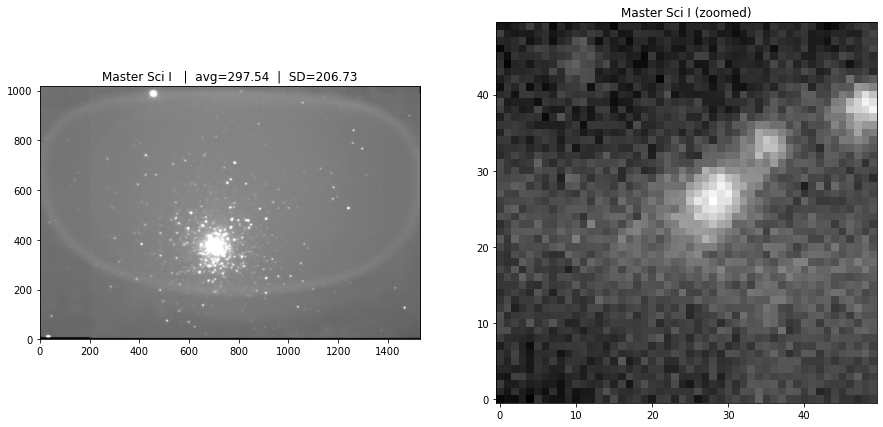

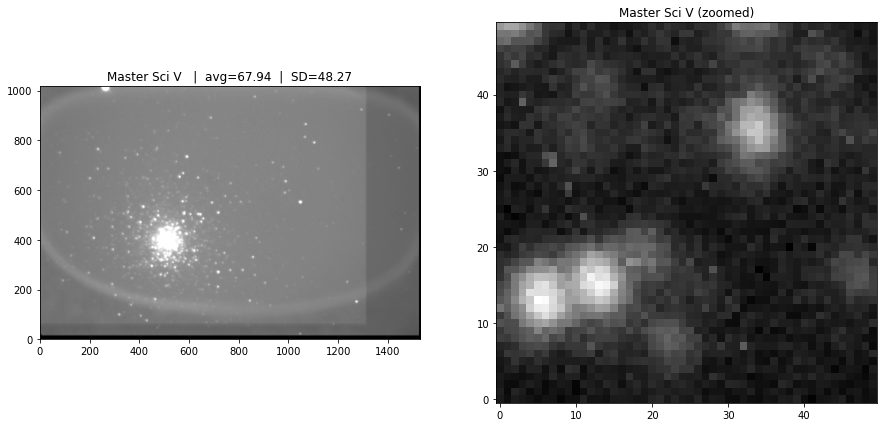

In [24]:
# Plot the median images

for im, cstr in zip(mast_scis, mag_strs):
    
    plt_v1(im, 
           t1='Master Sci ' + cstr + ' ', 
           t2='Master Sci ' + cstr + ' (zoomed)', 
           cmap='gray', #cstr + 's'
           rescale_img_q=True
          )

In [25]:
mast_scis_filt = np.copy(mast_scis)

In [26]:
if 1:
    for i in range(2):
        mast_scis_filt[i] = mast_scis_filt[i] - np.nanmin(mast_scis_filt[i])

In [27]:
for i in range(2):
    print(np.nanmin(mast_scis_filt[i]))

0.0
0.0


# Align images (color channels)

In [28]:
def normScale(input0, min0, max0):
    
    if np.size(input0, 0) == 0 or np.size(input0, 1) == 0:
        
        output0 = ( input0 - np.nanmin(input0) ) * ( max0 - min0 ) / ( np.nanmax(input0) - np.nanmin(input0) ) + min0
        
    else:
        
        minUni = np.nanmin(input0)
        maxUni = np.nanmax(input0)
        
        output0 = ( input0 - minUni ) * ( max0 - min0 ) / ( maxUni - minUni ) + min0
    
    return output0

In [29]:
mast_scis_filt_ali = []

for img, cstr in zip(mast_scis_filt, mag_strs):
    
    mast_sci_filt_ali, dx, dy = align_two_imgs(mast_scis_filt[0], img)
    
    mast_scis_filt_ali.append(mast_sci_filt_ali)

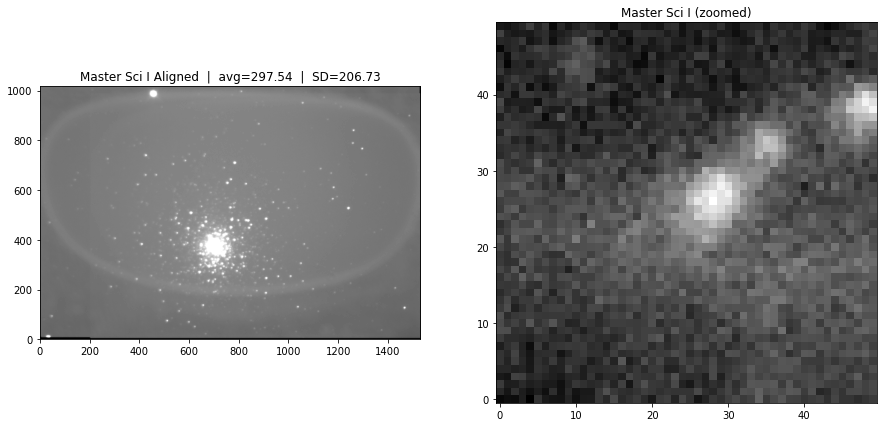

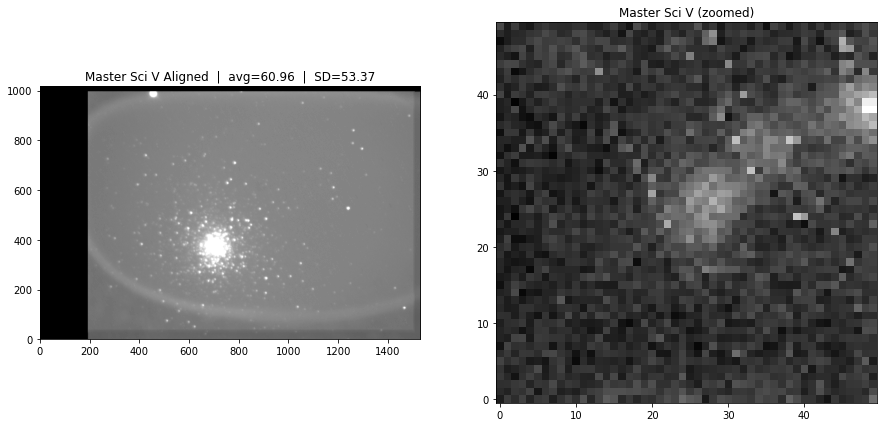

In [30]:
for im, cstr in zip(mast_scis_filt_ali, mag_strs):
    
    plt_v1(im, 
           t1='Master Sci ' + cstr + ' Aligned', 
           t2='Master Sci ' + cstr + ' (zoomed)', 
           cmap='gray', #cstr + 's'
           rescale_img_q=True
          )

In [31]:
sci = np.sum(np.stack(mast_scis_filt_ali, axis=2), axis=2)

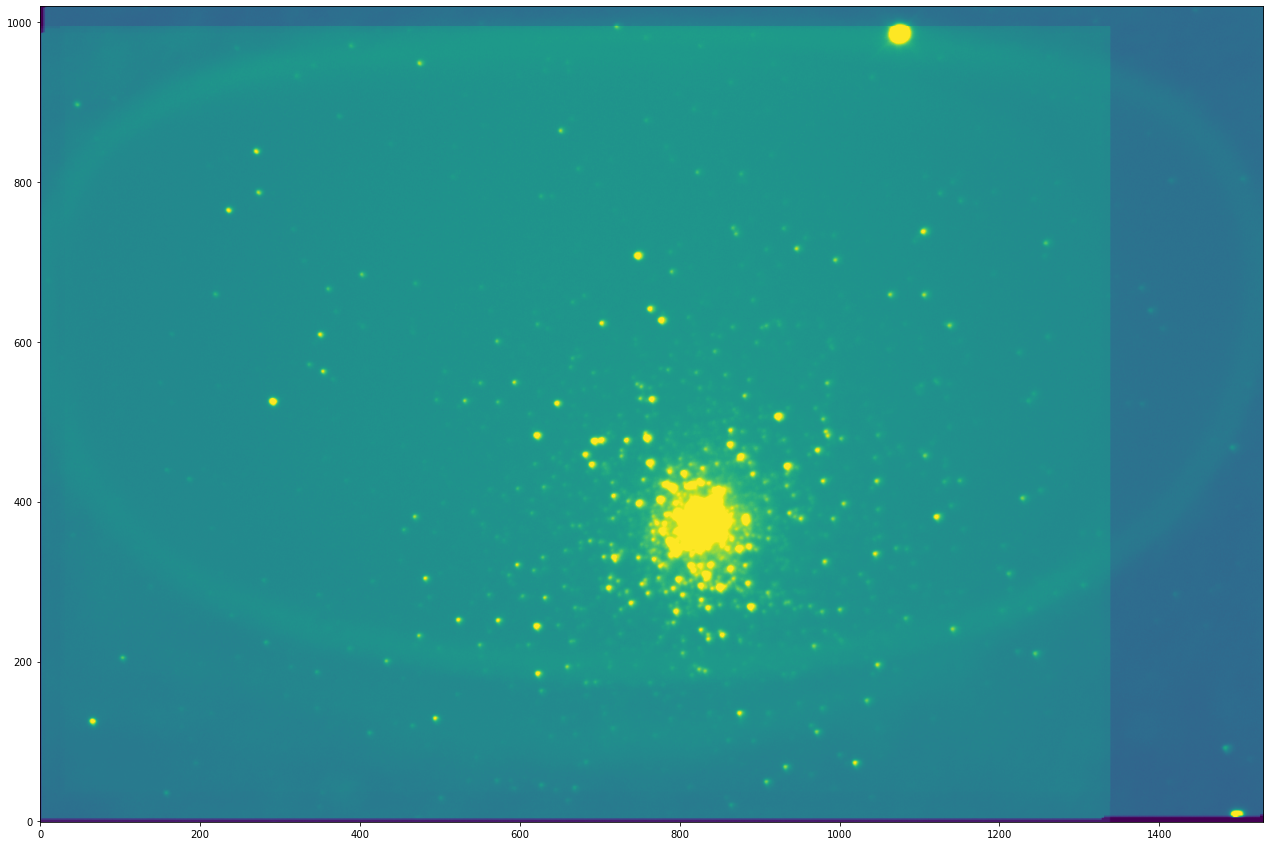

In [32]:
plt.figure(figsize=(25,15))
#plt.subplot(1,2,1)
plt.imshow(np.fliplr(rs(sci, 0.001, 99.5)), origin='bottom')

In [33]:
from skimage.feature import register_translation
import scipy.ndimage as ndimage

In [34]:
Iimage = mast_scis_filt_ali[0]
Vimage = mast_scis_filt_ali[1]

# Crop the final color frames

We need to get rid of any major unwanted features in the images

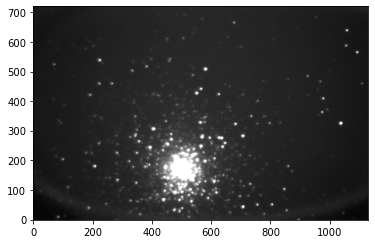


Satisfied? (y)   y


In [35]:
import matplotlib.colors as colr
from IPython.display import clear_output

#crop image

plt_img = rs(sci, 0.001, 99.5)

xlr=200
xrr=200
yur=200
ydr=100



#xlr=1
#xrr=1
#yur=1
#ydr=1

satisfied='n'
while str(satisfied) != 'y':
    
    clear_output()

    fig=plt.figure(22)
    fig.clf()
    plt.imshow(plt_img[yur:-ydr, xlr:-xrr], cmap="gray")#, norm=colr.LogNorm())
    #plt.imshow(Iimage)
    plt.gca().invert_yaxis()
    #plt.gca().invert_xaxis()
    plt.show(block=False)


    if 1:
        satisfied = input('\nSatisfied? (y)   ')

        if str(satisfied) != 'y':

            xl = input('\nX left cut. Current: ' + str(xlr)+'.    ')
            if xl!='':
                xlr = int(xl)
            xr = input('\nX right cut. Current: ' + str(xrr)+'.    ')
            if xr!='':
                xrr = int(xr)
            yu = input('\nY top cut. Current: ' + str(yur)+'.    ')
            if yu!='':
                yur = int(yu)
            yd = input('\nY bottom cut. Current: ' + str(ydr)+'.    ')
            if yd!='':
                ydr = int(yd)
        
    


Iimage=Iimage[yur:-ydr, xlr:-xrr]
Vimage=Vimage[yur:-ydr, xlr:-xrr]



In [36]:
np.shape(Vimage)

(720, 1130)

# Photometry mask

Chose an area to exclude form photometry measurements. Here I exclude the center of this cluster because there are too many overlapping stars.

In [37]:
plt_img0 = rs(Iimage + Vimage, 0.001, 99.5)

# Photometry Measurements

**Manual Photometry**

In [38]:
# Manual photometry

def show_star_position(x, y, img, plot_q=True):
    
    b = 50
    
    plt.figure(figsize=(18,18))
    plt.subplot(121)
    plt.imshow(img, origin='lower', cmap='viridis')
    plt.axhline(y, c='r')
    plt.axvline(x, c='g')
    
    plt.subplot(122)
    plt.imshow(img, origin='lower', cmap='viridis')
    plt.xlim(x - b, x + b)
    plt.ylim(y - b, y + b)
    plt.axhline(y, c='r')
    plt.axvline(x, c='g')
    
    
def set_phot_meas_rad(x, y, meas_radius, img, plot_q=True):
    
    from matplotlib.patches import Circle
    
    b = meas_radius + 10
    
    plt.figure(figsize=(18,18))
    ax = plt.subplot(111)
    plt.imshow(img, origin='lower', cmap='viridis')
    plt.xlim(x - b, x + b)
    plt.ylim(y - b, y + b)
    plt.axhline(y, c='r')
    plt.axvline(x, c='g')
    ax.add_patch(Circle((x,y), meas_radius, edgecolor='r', facecolor=None, fill=False))
    
    
def set_bkg_meas_rad(x, y, meas_phot_radius, meas_inner_radius, meas_outer_radius, img, plot_q=True):
    
    from matplotlib.patches import Circle
    
    alphas = 0.1
    pho_color = 'r'
    bkg_color = 'c'
    
    b = meas_outer_radius + 10
    
    # Fill annulus calcs
    theta = np.linspace(0, 2*np.pi, 50, endpoint=True)
    xs = np.outer([meas_inner_radius, meas_outer_radius], np.cos(theta)) + x
    ys = np.outer([meas_inner_radius, meas_outer_radius], np.sin(theta)) + y
    #print(xs, ys)
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    
    plt.figure(figsize=(18,18))
    ax = plt.subplot(111)
    plt.imshow(img, origin='lower', cmap='viridis')
    plt.xlim(x - b, x + b)
    plt.ylim(y - b, y + b)
    plt.axhline(y, c='r')
    plt.axvline(x, c='g')
    
    ax.add_patch(Circle((x,y), meas_phot_radius, edgecolor=pho_color, facecolor=[1, 0, 0, alphas], fill=1))
    ax.add_patch(Circle((x,y), meas_inner_radius, edgecolor=bkg_color, facecolor=None, fill=False))
    ax.add_patch(Circle((x,y), meas_outer_radius, edgecolor=bkg_color, facecolor=None, fill=False))
    
    ax.fill(np.ravel(xs), np.ravel(ys), color=bkg_color, edgecolor=bkg_color, facecolor=bkg_color, alpha=alphas, zorder=10)
    
    
def meas_total_star_flux(x, y, meas_phot_radius, img, plot_q=True):
    
    apertures = CircularAperture((x, y), r=meas_phot_radius)
    
    Iphot_table = aperture_photometry(img, apertures, method='exact')
    
    return np.asarray(Iphot_table['aperture_sum'])[0]


def meas_total_background_flux(x, y, meas_phot_radius, meas_inner_radius, meas_outer_radius, img, plot_q=True):
    
    aperture = CircularAperture((x, y), 
                                r=meas_phot_radius)
    
    annulus_aperture = CircularAnnulus((x, y), 
                                       r_in=meas_inner_radius, 
                                       r_out=meas_outer_radius)
    
    annulus_mask = annulus_aperture.to_mask(method='exact')
    
    annulus_data = annulus_mask.multiply(img)
    
    annulus_data_1d = annulus_data[annulus_data != 0]
    
    _, bkg_median, _ = sigma_clipped_stats(annulus_data_1d, 
                                           sigma_lower=3, sigma_upper=1)
    
    return bkg_median * aperture.area
    
    
def flux2mag(flux):
    
    adu2e = 2.5399999618530273 # ADU to electrons

    return -2.5 * np.log10(adu2e * flux / 10)

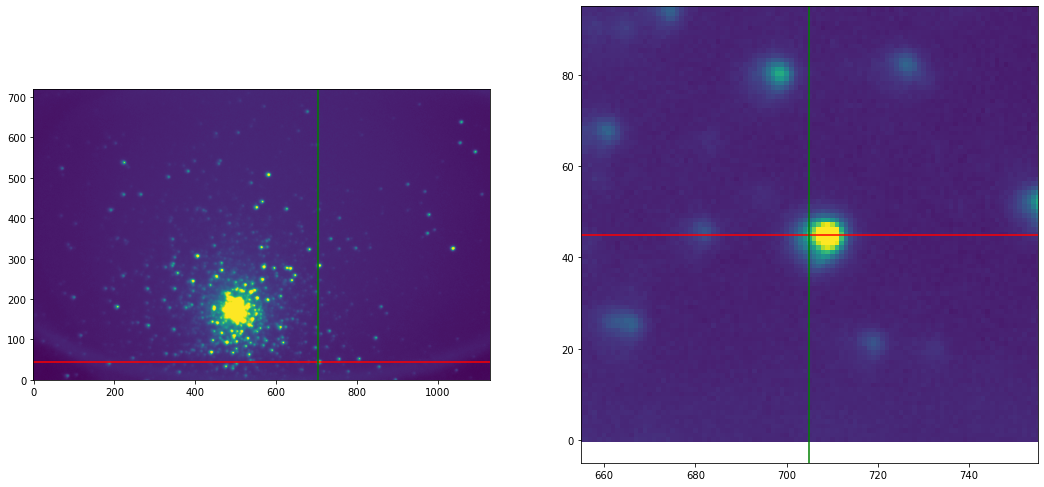

In [59]:
# Use this to find the xy positions of a star

# x = 562
# y = 328

x = 705
y = 45

#x = 437
#y = 233

show_star_position(x, y, img=plt_img0, plot_q=True)

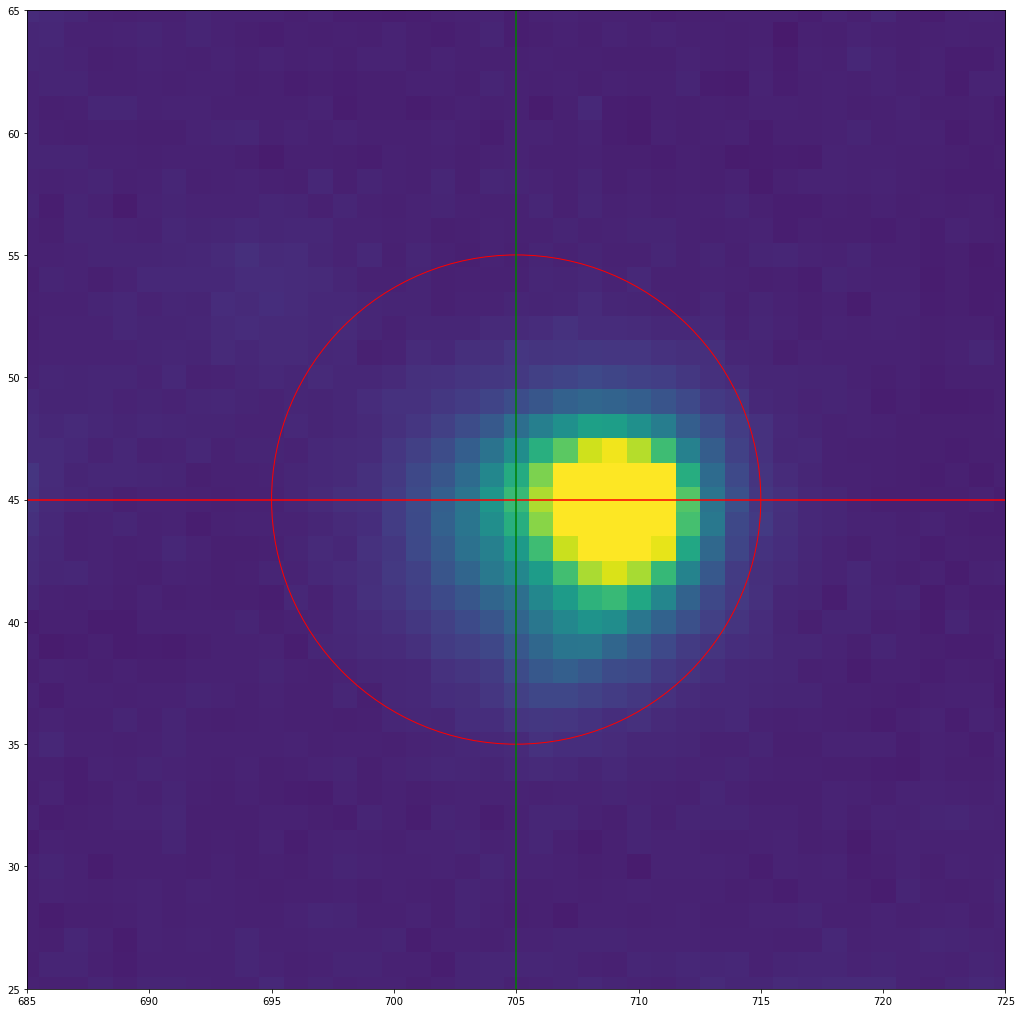

In [60]:
# Use this only once to find the radius of a star. The pixels
#    within this radus will be summed to obtian the total flux 
#    of each star.

meas_phot_radius = 10
# meas_phot_radius = 9

set_phot_meas_rad(x, y, meas_phot_radius, img=plt_img0, plot_q=True)

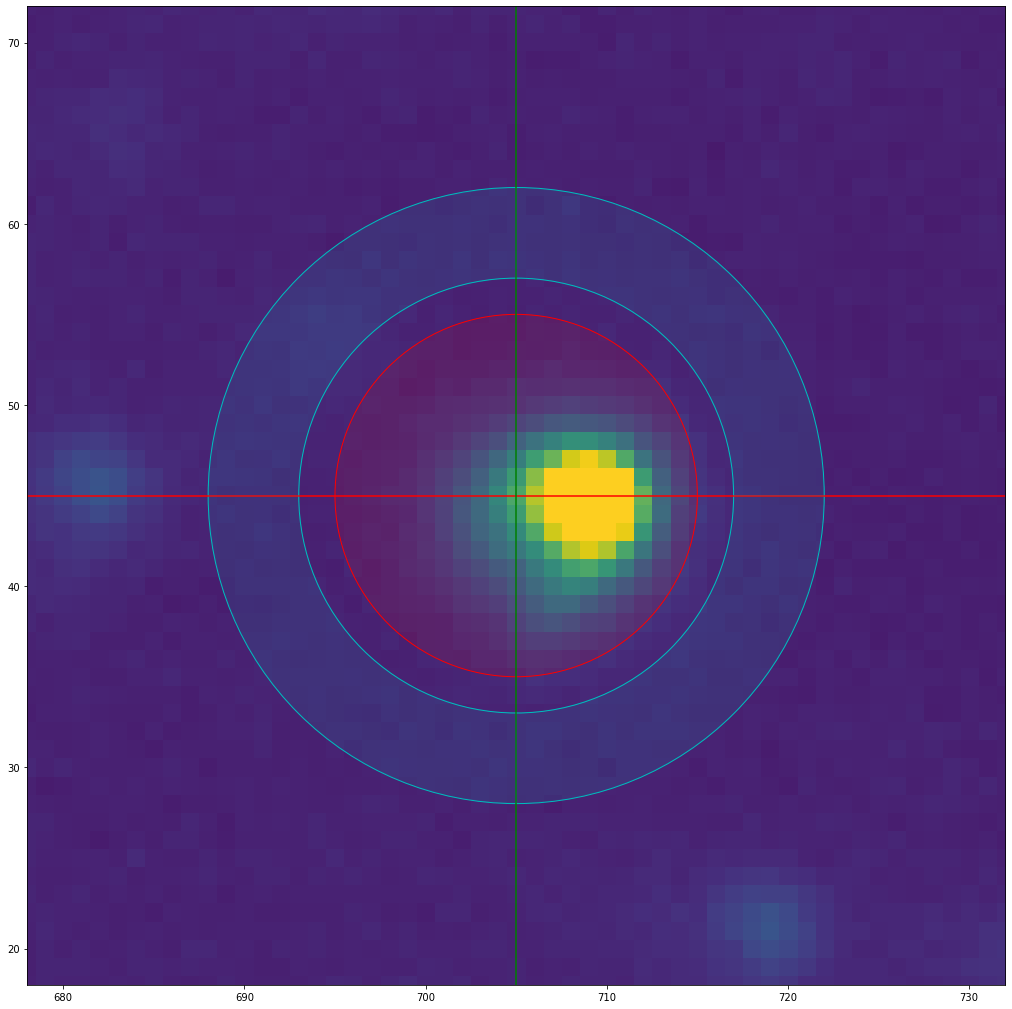

In [61]:
# Use this only once to define the "annulus", a ring around 
#    each star whos pixels will be used to determine the 
#    background flux of each star. The sky is not perfectly dark,
#    so we have to find what flux is being included with the star
#    flux. Mathematically, 
#      measured_star_flux = actual_star_flux + background_flux
#    So we measure the "background_flux" so that we can solve
#    for "actual_star_flux".

meas_inner_radius = 12
meas_outer_radius = 17

set_bkg_meas_rad(x, y, 
                 meas_phot_radius, 
                 meas_inner_radius, 
                 meas_outer_radius, 
                 img=plt_img0, plot_q=True)

In [62]:
# Measure the tatal flux of the star

star_flux_v = meas_total_star_flux(x, y, meas_phot_radius, img=Vimage, plot_q=True)
star_flux_i = meas_total_star_flux(x, y, meas_phot_radius, img=Iimage, plot_q=True)

star_flux_v, star_flux_i

(32456.967064206015, 129741.89438164703)

In [63]:
# Measure the tatal background flux in the annulus and convert 
#    it to the total backgroud flux in the star circle.
#    Mathematically,
#    bkg_total_flux_at_star = avg_bkg_flux * star_circle_area

bkg_flux_v = meas_total_background_flux(x, y,
                                        meas_phot_radius, 
                                        meas_inner_radius, 
                                        meas_outer_radius, 
                                        img=Vimage, plot_q=True)

bkg_flux_i = meas_total_background_flux(x, y,
                                        meas_phot_radius, 
                                        meas_inner_radius, 
                                        meas_outer_radius, 
                                        img=Iimage, plot_q=True)

bkg_flux_v, bkg_flux_i

(22573.714129851483, 95045.20203659708)

In [64]:
# Subtract the background total flux from that of the star

star_flux_calib_v = star_flux_v - bkg_flux_v
star_flux_calib_i = star_flux_i - bkg_flux_i

star_flux_calib_v, star_flux_calib_i

(9883.252934354532, 34696.692345049945)

In [65]:
# Convert flux to magnitude

star_mag_v = flux2mag(star_flux_calib_v)
star_mag_i = flux2mag(star_flux_calib_i)

star_mag_v, star_mag_i

(-8.499334050408205, -9.86280446331877)